In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
import numpy as np

In [2]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])

    ell = Ellipse(xy=pos, width=v[0]*nstd, height=v[1]*nstd,
                  angle=np.degrees(np.arctan(u[1] / u[0])), **kwargs)
    ell.set_facecolor('none')
    ax.add_patch(ell)

In [3]:
data = pd.read_csv("Datasets/blobs.csv")
y_true = data['y']
data = data.drop('y', axis=1)

In [4]:
n_components = 8
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)
y_pred = gmm.predict(data)
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

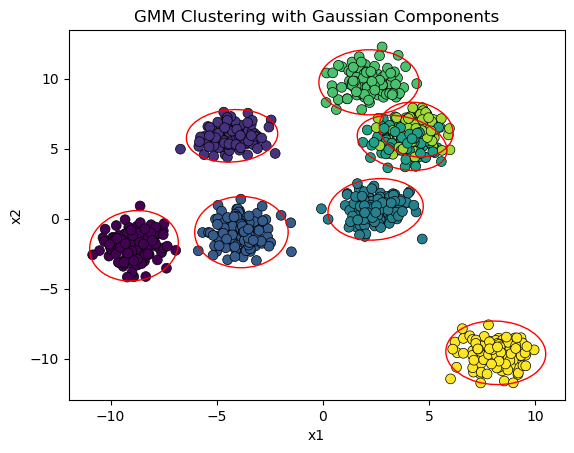

In [5]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_true, cmap='viridis', s=50, edgecolors='k', linewidth=0.5)

for i in range(n_components):
    plot_cov_ellipse(covariances[i], means[i], nstd=2, ax=plt.gca(), edgecolor='red')

plt.title('GMM Clustering with Gaussian Components')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [6]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)
fmi = fowlkes_mallows_score(y_true, y_pred)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"Fowlkes-Mallows Index: {fmi:.4f}")


Adjusted Rand Index: 0.8777
Normalized Mutual Information: 0.9242
Fowlkes-Mallows Index: 0.8929


In [17]:
from Model import GaussianMixtureModel
n_components=8
model = GaussianMixtureModel(n_components)
X = np.array(data)
model.fit(X)
predicted_labels = model.predict(X)
means = model.means
covariances = model.covariances
weights = model.weights

In [18]:
ari = adjusted_rand_score(y_true, predicted_labels)
nmi = normalized_mutual_info_score(y_true, predicted_labels)
fmi = fowlkes_mallows_score(y_true, predicted_labels)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"Fowlkes-Mallows Index: {fmi:.4f}")

Adjusted Rand Index: 0.8646
Normalized Mutual Information: 0.9496
Fowlkes-Mallows Index: 0.8884


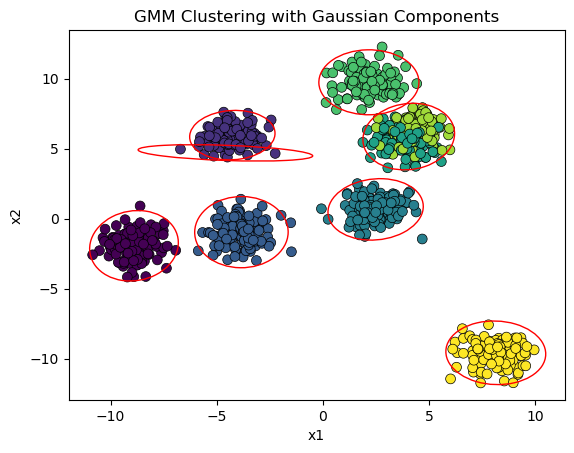

In [19]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_true, cmap='viridis', s=50, edgecolors='k', linewidth=0.5)

for i in range(n_components):
    plot_cov_ellipse(covariances[i], means[i], nstd=2, ax=plt.gca(), edgecolor='red')

plt.title('GMM Clustering with Gaussian Components')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()